In [5]:
import functions as mf
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

import importlib
importlib.reload(mf)

<module 'functions' from 'c:\\Users\\brent\\Documents\\comp_multphase_flow\\functions.py'>

In [25]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 1096 # kg/m3
diameter_RBC = 8e-6 # m

y_end = 5e-3 # m
Ny = 100

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma)
mu = system.calc_mu(mu_plasma)

# Plan van aanpak
1D model
1. define system parameters
2. solve laminar
3. solve prantdl in while loop
4. solve wall function in while loop
5. solve alpha2
6. solve velocity u

43
0.00018517128339629353 0.000185


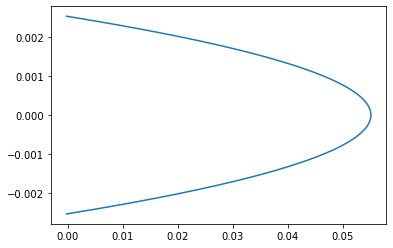

In [27]:
# Prescribed flow rate
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity

print(len(switch))
plt.plot(velocity, system.y)
print(Q, Q_des)

# Brentl mixing length

In [ ]:
argument_type = None

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_new, system.y, label="pml")
plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()